In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from ema_workbench.analysis.plotting_util import *
from ema_workbench.analysis.plotting import *
import ema_workbench.analysis.prim as prim
from functools import reduce

## Prepare Ventity data

In [2]:
def import_results(path):
    # Collect all the files in the directory path that end with .csv
    csv_files = [file for file in os.listdir(path) if file.endswith('.csv')]

    # Create a dictionairy to group the files with same policy
    file_sets_dict = {}

    # Group files with same policy based on the text before the first underscore
    for csv_file in csv_files:
        base_name = os.path.basename(csv_file)
        prefix = base_name.split('_')[0]

        if prefix not in file_sets_dict:
            file_sets_dict[prefix] = []

        file_sets_dict[prefix].append(base_name)

    # Display the dictionary as a list of lists
    file_sets = list(file_sets_dict.values())
    
    return file_sets

In [3]:
# Specify your directory path
directory_path = os.getcwd() + "\\Demo model\\Results\\"

file_sets = import_results(directory_path)
file_sets

[['CCBC_collection_of_country.csv',
  'CCBC_collection_of_world.csv',
  'CCBC_country.csv',
  'CCBC_model.csv',
  'CCBC_world.csv'],
 ['CC_collection_of_country.csv',
  'CC_collection_of_world.csv',
  'CC_country.csv',
  'CC_model.csv',
  'CC_world.csv'],
 ['Zero_collection_of_country.csv',
  'Zero_collection_of_world.csv',
  'Zero_country.csv',
  'Zero_model.csv',
  'Zero_world.csv']]

In [4]:
def prepare_results(path, file_sets):
    # Create a list that will contain all results of entitytypes and policies
    all_dfs = []

    # Loop through each policy file set
    for file_set in file_sets:
        dfs_per_policy = []
        last_df = None
        
        # Loop through each entitytype per policy file set
        for file_name in file_set:
            # Read and store .csv files
            file_path = os.path.join(path, file_name)
            df = pd.read_csv(file_path, header=1)

            # Replace potential NaN values in EntityID column 
            if df['Entity ID'].isna().any():
                parts_after_underscore = file_name.split('_')[1:]
                entitytype_name = '_'.join(parts_after_underscore).split('.')[0]
                df['Entity ID'] = df['Entity ID'].fillna(entitytype_name)

            # Create column with policy name
            policy_name = file_name.split('_')[0]
            df['Policy'] = policy_name

            # Get unique 'Entity ID' values
            entity_IDs = df['Entity ID'].value_counts().index

            # Create an empty DataFrame with 'Run' and 'DateTime'
            new_df = pd.DataFrame({'Run': df['Run'], 'DateTime': df['DateTime'], 'Policy': df['Policy']})

            # Loop through unique 'Entity ID' values
            for entity_ID in entity_IDs:
                # Select rows for the current 'Entity ID'
                entity_df = df[df['Entity ID'] == entity_ID].copy()

                # Rename columns by adding 'Entity ID' as a suffix
                entity_df.columns = [f'{col} {entity_ID}' if col not in ['Run', 'DateTime', 'Policy'] 
                                     else col for col in entity_df.columns]

                # Merge on 'Run' and 'DateTime'
                new_df = pd.merge(new_df, entity_df, left_on=['Run', 'DateTime', 'Policy'], 
                                  right_on=['Run', 'DateTime', 'Policy'], how='left').drop_duplicates()
                
            # Merge new_df with previous df in loop and store the merged df as previous df
            if last_df is None:
                last_df = new_df
            else:
                last_df = pd.merge(last_df, new_df, on=['Run','DateTime', 'Policy'], how='left')


        all_dfs.append(last_df)

    # Merge into one dataframe
    final_df = pd.concat(all_dfs, ignore_index=True)
    
    # Create a Scenario column
    final_df['scenario'] = (final_df['Run'] != final_df['Run'].shift()).cumsum()
    
    return final_df

In [5]:
prepared_df = prepare_results(directory_path, file_sets)
prepared_df

,Run,DateTime,Policy,Entity ID collection_of_country,Count collection_of_country,Sum Birth rate collection_of_country,Sum Population collection_of_country,Entity ID collection_of_world,Count collection_of_world,Entity ID NL,...,CO2 emission per person OneWorld,Carbon capture delay.1 OneWorld,Carrying capacity OneWorld,CO2 OneWorld,CO2 emission per person.1 OneWorld,Emission rate OneWorld,Fraction CO2 of carrying capacity OneWorld,Policy carbon capture OneWorld,Uptake CO2 OneWorld,scenario
0,1,0,CCBC,collection_of_country,2,1.746284,150.000000,collection_of_world,1,NL,...,6.938454,47.263936,5000,1000.000000,6.938454,12.116507,0.200000,1,21.157781,1
1,1,1,CCBC,collection_of_country,2,1.745194,149.578666,collection_of_world,1,NL,...,6.938454,47.263936,5000,991.038708,6.938454,12.108946,0.198208,1,20.968180,1
2,1,2,CCBC,collection_of_country,2,1.744065,149.162383,collection_of_world,1,NL,...,6.938454,47.263936,5000,982.257661,6.938454,12.101112,0.196452,1,20.782392,1
3,1,3,CCBC,collection_of_country,2,1.742898,148.751036,collection_of_world,1,NL,...,6.938454,47.263936,5000,973.652812,6.938454,12.093014,0.194731,1,20.600333,1
4,1,4,CCBC,collection_of_country,2,1.741694,148.344517,collection_of_world,1,NL,...,6.938454,47.263936,5000,965.220211,6.938454,12.084661,0.193044,1,20.421918,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30295,100,96,Zero,collection_of_country,2,0.172075,10.473874,collection_of_world,1,NL,...,14.963707,59.851878,5000,3347.266142,14.963707,2.574887,0.669453,0,0.000000,300
30296,100,97,Zero,collection_of_country,2,0.166139,10.128052,collection_of_world,1,NL,...,14.963707,59.851878,5000,3349.801902,14.963707,2.486050,0.669960,0,0.000000,300
30297,100,98,Zero,collection_of_country,2,0.160411,9.793403,collection_of_world,1,NL,...,14.963707,59.851878,5000,3352.250203,14.963707,2.400341,0.670450,0,0.000000,300
30298,100,99,Zero,collection_of_country,2,0.154884,9.469585,collection_of_world,1,NL,...,14.963707,59.851878,5000,3354.614121,14.963707,2.317644,0.670923,0,0.000000,300


In [6]:
prepared_df.columns

Index(['Run', 'DateTime', 'Policy', 'Entity ID collection_of_country',
       'Count collection_of_country', 'Sum Birth rate collection_of_country',
       'Sum Population collection_of_country', 'Entity ID collection_of_world',
       'Count collection_of_world', 'Entity ID NL', 'Fractional birth rate NL',
       'Fractional death rate NL', 'Birth rate NL',
       'Birth stop due pollution NL', 'Death rate NL',
       'Fractional birth rate.1 NL', 'Fractional death rate.1 NL',
       'Policy birth control NL', 'Population NL', 'Entity ID BE',
       'Fractional birth rate BE', 'Fractional death rate BE', 'Birth rate BE',
       'Birth stop due pollution BE', 'Death rate BE',
       'Fractional birth rate.1 BE', 'Fractional death rate.1 BE',
       'Policy birth control BE', 'Population BE', 'Entity ID model',
       'Final Time model', 'Initial Time model', 'Noise Seed model',
       'Time model', 'Time Step model', 'Entity ID OneWorld',
       'Carbon capture delay OneWorld', 'CO2 em

## Create EMA_workbench format

In [7]:
def create_experimental_data(prepared_df,parameters,outcomes):
    # Create dataframe with uncertainties and policy
    df_poi = prepared_df[parameters]
    df_poi = df_poi[~df_poi.duplicated(subset=parameters, keep='first')].reset_index(drop=True)
    
    # Create dictionairy with outcomes
    dict_ooi = {}

    # Put time series data in dictionairy as value with outcome as key
    for col in outcomes:
        grouped_data = prepared_df.groupby('scenario')[col].apply(list).to_dict()
        dict_ooi[col] = np.array(list(grouped_data.values()))

    return df_poi, dict_ooi

In [8]:
# Specify parameters of interest
uncertainties = ['Fractional birth rate NL', 'Fractional death rate NL',
                 'Fractional birth rate BE', 'Fractional death rate BE',
                 'Carbon capture delay OneWorld', 'CO2 emission per person OneWorld']

levers = []

# If multiple policy file sets exist, append the policy column
if 'Policy' in prepared_df.columns: 
    poi = uncertainties + levers + ['Policy']

# Specify outcomes of interest
ooi = ['Sum Population collection_of_country','CO2 OneWorld']

In [9]:
x,o = create_experimental_data(prepared_df,poi,ooi)
x,o

(     Fractional birth rate NL  Fractional death rate NL  \
 0                    0.033005                  0.016211   
 1                    0.031675                  0.022649   
 2                    0.010546                  0.020110   
 3                    0.028570                  0.027969   
 4                    0.034090                  0.027531   
 ..                        ...                       ...   
 295                  0.017460                  0.023924   
 296                  0.041511                  0.045698   
 297                  0.034520                  0.025691   
 298                  0.033503                  0.022571   
 299                  0.049690                  0.049934   
 
      Fractional birth rate BE  Fractional death rate BE  \
 0                    0.021305                  0.010976   
 1                    0.021606                  0.040757   
 2                    0.029143                  0.022279   
 3                    0.019627        

# Test

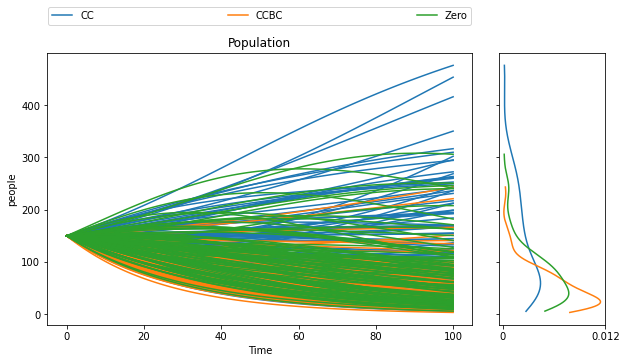

In [10]:
lines(x,o,outcomes_to_show=['Sum Population collection_of_country'],group_by = 'Policy',
      titles= {'Sum Population collection_of_country':'Population'},
      ylabels={'Sum Population collection_of_country':'people'},
      legend=True, density=Density.KDE)

plt.show()